Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/exercises/exercise07/exercise07.ipynb)

# Exercise 7

## Problem

In week 7, you learned how to extend tabular data with geospatial information: points, linestrings, and polygons.

For this next exercise, please ask a planning-related question with a spatial component, then find data and apply any data science methods you have learned so-far (or can Google!) to answer that question.

## Data

You are welcome to use any data you would like, including data used in previous demos and exercises.

## A Few Pointers
- Choose a straightforward question that requires a reasonable amount of data! Don't shoot for the moon. This exercise is intended to give you a chance to practice finding and analyzing spatial data, not to address the world's greatest challenges.
- Consider using this exercise to get a head start on your final project or explore options for it. Your project doesn't need to focus on spatial analysis for it to play a role. Are there datasets you might join together based on spatial locations?
- Don't go overboard. If you're hitting a wall with coding, write pseudocode and turn that in. Don't let the perfect be the enemy of the done. But if you're energized and having fun by chasing down a thorny solution to a coding problem, by all means feel free to keep at it!



Proposal Title: Analyzing Bike Share Station Utilization Patterns in Ward 7, Washington, DC

Introduction:
Equitable access to sustainable transportation options, such as bike share systems, is a key priority for planners and policymakers aiming to improve mobility and quality of life for all residents. In Washington, DC, the Capital Bikeshare program has expanded rapidly since its launch in 2010, yet concerns remain about ensuring accessibility across different neighborhoods.

Ward 7, located in the eastern part of the city, has historically faced transportation challenges and limited access to various mobility options. Understanding the distribution and usage patterns of bike share stations in this community can provide valuable insights to guide future planning and investment decisions.

Research Questions:
1. How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?
2. What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt

In [ ]:
wards_dc = gpd.read_file('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/wards_dc')
ward7_boundary = wards_dc[wards_dc['WARD'] == 7]
# Load census tract data
census_tracts = gpd.read_file('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/census_tracts')
# Load zoning designated data
zoning = gpd.read_file('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/Zoning_Downtown_Designated_Streets')
# load street centerlines or characteristics data
street_centerlines = gpd.read_file('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/Street_Centerlines_2013')
# Load bikeshare trip data
bikeshare_trip_data = pd.read_csv('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/202312-capitalbikeshare-tripdata/202312-capitalbikeshare-tripdata.csv')



In [ ]:
# URL of the station information API endpoint
url = "https://gbfs.lyft.com/gbfs/2.3/dca-cabi/en/station_information.json"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the station data to a file
    with open("bike_stations.json", "w") as file:
        file.write(response.text)
    print("Station data downloaded successfully!")
else:
    print("Failed to download station data.")

# Load the JSON data
with open("bike_stations.json", "r") as file:
    data = json.load(file)
# Convert the data to a pandas DataFrame
bikeshare_station = pd.DataFrame(data["data"]["stations"])
# Convert the bikeshare_station DataFrame to a GeoDataFrame
bikeshare_station_gdf = gpd.GeoDataFrame(bikeshare_station, geometry=gpd.points_from_xy(bikeshare_station['lon'], bikeshare_station['lat']), crs='EPSG:4326')


Station data downloaded successfully!


Research Question 1: How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?

Approach to Answering question one

In [ ]:
# Store the EPSG code for UTM18
UTM18 = 26918

# Store the EPSG code for WGS84
WGS84 = 4326

# Reproject one of the GeoDataFrames to match the CRS of the other
bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=4326)
# Perform spatial join
bikeshare_stations_in_ward7 = gpd.sjoin(bikeshare_station_gdf, ward7_boundary.to_crs(epsg=4326), how='inner', predicate='within')

# Re-project the geometries to UTM18 CRS
census_tracts = census_tracts.to_crs(epsg=UTM18)

# Calculate the centroid of each census tract
census_tracts['centroid'] = census_tracts.centroid

# Find the nearest bike share station for each census tract centroid
def find_nearest_station(row):
    nearest_station = min(bikeshare_stations_in_ward7.geometry, key=lambda g: g.distance(row.centroid))
    return nearest_station

census_tracts['nearest_station'] = census_tracts.apply(find_nearest_station, axis=1)

# Calculate the distance from each census tract centroid to the nearest bike share station
census_tracts['nearest_station_dist'] = census_tracts.apply(lambda row: row.centroid.distance(row.nearest_station), axis=1)
census_tracts['nearest_station_dist']


0      4.321111e+06
1      4.321504e+06
2      4.320288e+06
3      4.322077e+06
4      4.322527e+06
           ...     
201    4.323523e+06
202    4.323185e+06
203    4.323385e+06
204    4.322205e+06
205    4.322277e+06
Name: nearest_station_dist, Length: 206, dtype: float64

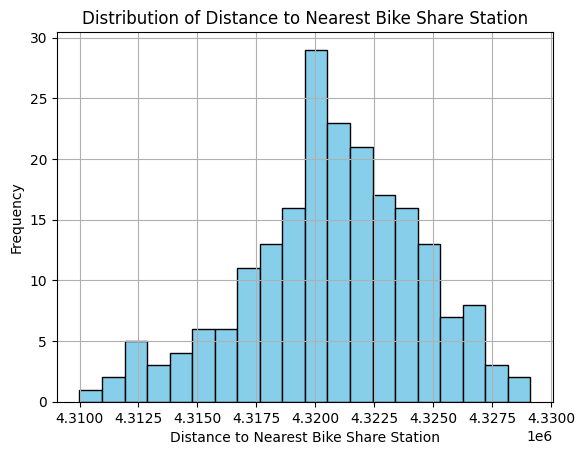

In [ ]:
# Plot a histogram of nearest station distances
plt.hist(census_tracts['nearest_station_dist'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance to Nearest Bike Share Station')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to Nearest Bike Share Station')
plt.grid(True)

plt.show()

In [ ]:
# Create a map centered on Ward 7
ward7_centroid = census_tracts.geometry.unary_union.centroid
m = folium.Map(location=[ward7_centroid.y, ward7_centroid.x], zoom_start=12)

# Add the census tract boundaries to the map
folium.GeoJson(census_tracts, name='census_tracts').add_to(m)

# Add the bike share station locations to the map
for idx, station in bikeshare_stations_in_ward7.iterrows():
    folium.Marker(
        location=[station.geometry.y, station.geometry.x],
        popup=station['name'],
        icon=folium.Icon(color='blue', icon='bicycle')
    ).add_to(m)
# Create a choropleth map to visualize the accessibility metrics
if 'nearest_station_dist' in census_tracts.columns:
    census_tracts_geojson = census_tracts.to_json()
    m.choropleth(
        geo_data=census_tracts_geojson,
        name='Accessibility',
        data=census_tracts,
        columns=['NAME', 'nearest_station_dist'],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Distance to Nearest Bike Share Station (meters)'
    )
else:
    print("The 'nearest_station_dist' column does not exist in the census_tracts GeoDataFrame.")

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m

Question 2:  What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

Working towards answering question 2 below:

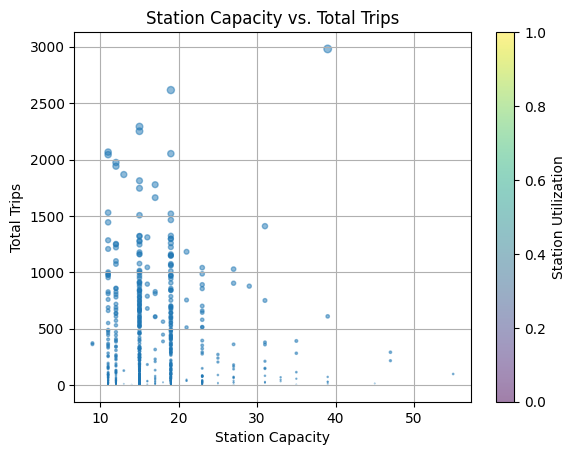

In [ ]:
# Load the bike share station data
bikeshare_station_gdf = gpd.GeoDataFrame(bikeshare_station_gdf, geometry=gpd.points_from_xy(bikeshare_station_gdf['lon'], bikeshare_station_gdf['lat']))

# Reproject the geometries to a common coordinate system (UTM18)
bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=UTM18)
zoning = zoning.to_crs(epsg=UTM18)
street_centerlines = street_centerlines.to_crs(epsg=UTM18)

# Extract relevant station-level features
station_level_features = bikeshare_station_gdf[['station_id', 'name', 'capacity', 'lon', 'lat']]

# Merge the station level features data with the zoning data based on a common key
bikeshare_stations_with_zoning = gpd.sjoin(bikeshare_station_gdf, zoning, how='left', predicate='intersects')

# Convert 'started_at' and 'ended_at' columns to datetime objects
bikeshare_trip_data['started_at'] = pd.to_datetime(bikeshare_trip_data['started_at'])
bikeshare_trip_data['ended_at'] = pd.to_datetime(bikeshare_trip_data['ended_at'])

# Calculate trip duration in seconds
bikeshare_trip_data['trip_duration'] = (bikeshare_trip_data['ended_at'] - bikeshare_trip_data['started_at']).dt.total_seconds()

# Group the trip data by start station and calculate utilization metrics
station_utilization = bikeshare_trip_data.groupby('start_station_id')[['trip_duration']].agg(['count', 'mean'])
station_utilization.columns = ['total_trips', 'avg_trip_duration']
station_utilization = station_utilization.reset_index()
station_utilization.head(2)

# Re-project the 'bikeshare_stations_with_zoning' DataFrame to a common CRS
bikeshare_stations_with_zoning = bikeshare_stations_with_zoning.to_crs(epsg=3857)

# Merge the station-level features and utilization metrics
bikeshare_stations_with_data_combined_df = pd.concat([bikeshare_stations_with_zoning, station_utilization], axis=1)
bikeshare_stations_with_data_combined_df.head(2)

import matplotlib.pyplot as plt

# Define marker size based on station utilization
marker_size = bikeshare_stations_with_data_combined_df['total_trips'] / 100

# Create a bubble plot of station capacity vs. total trips
plt.scatter(bikeshare_stations_with_data_combined_df['capacity'],
            bikeshare_stations_with_data_combined_df['total_trips'],
            s=marker_size, alpha=0.5)

plt.xlabel('Station Capacity')
plt.ylabel('Total Trips')
plt.title('Station Capacity vs. Total Trips')

# Add a color bar legend for marker sizes
plt.colorbar(label='Station Utilization')

plt.grid(True)
plt.show()


In [ ]:
# Calculate correlation between station capacity and total trips
correlation = bikeshare_stations_with_data_combined_df[['capacity', 'total_trips']].corr().iloc[0, 1]
print(f'Correlation between station capacity and total trips: {correlation:.2f}')

Correlation between station capacity and total trips: -0.04


In [ ]:
# Create a map centered on Ward 7
ward7_centroid = bikeshare_stations_with_data_combined_df.geometry.unary_union.centroid

m = folium.Map(location=[ward7_centroid.y, ward7_centroid.x], zoom_start=12)

# Add the bike share stations to the map, colored by utilization
for _, row in bikeshare_stations_with_data_combined_df.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['name'],
        icon=folium.Icon(color='blue' if row['total_trips'] < 1000 else 'red', icon='bicycle')
    ).add_to(m)

# Add the zoning information to the map
folium.GeoJson(zoning, name='Zoning').add_to(m)

# Display the map
m
